<a href="https://colab.research.google.com/github/SriSaiRatnaAbhishekKosuri128922/Tic-Tac-Toe-AI/blob/main/RL_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Tic-Tac-Toe AI**

Done By:
Sri Sai Ratna Abhishek Kosuri (21BCE7141)

# **1. Introduction**

This project focuses on developing a Q-learning-based Tic-Tac-Toe agent capable of playing against itself or a human.
Key features:
- Training an agent using Q-learning
- Tracking performance metrics (win, loss, draw rates)
- Retraining the model with human-played moves

# **2. Initial Setup**

Import required libraries and initialize key parameters, including the Tic-Tac-Toe board, players, Q-table, and hyperparameters.


In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Initialize the Tic-Tac-Toe board, players, Q-table, and metrics
board = np.array([[' ', ' ', ' '], [' ', ' ', ' '], [' ', ' ', ' ']])
players = ['X', 'O']
num_players = len(players)

# Hyperparameters
learning_rate = 0.01
discount_factor = 0.95
exploration_rate = 0.8
exploration_decay = 0.9999
num_episodes = 1000000

# Initialize Q-table and human-played games storage
Q = {}
human_played_games = []

wins, losses, draws = 0, 0, 0
win_rates, loss_rates, draw_rates, accuracies = [], [], [], []


# **FLOW DIAGRAM**

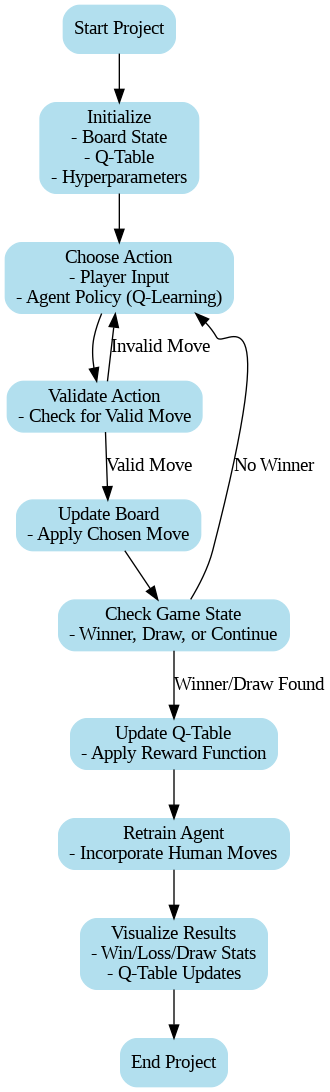

In [ ]:
# Step 1: Install graphviz
!pip install graphviz

# Step 2: Import the required library
from graphviz import Digraph

# Step 3: Create the flow diagram
flow = Digraph("Tic-Tac-Toe AI", format="png", node_attr={'shape': 'box', 'style': 'rounded,filled', 'color': 'lightblue2'})

# Step 4: Define the steps for the flowchart
flow.node("Start", "Start Project")
flow.node("Initialize", "Initialize\n- Board State\n- Q-Table\n- Hyperparameters")
flow.node("ChooseAction", "Choose Action\n- Player Input\n- Agent Policy (Q-Learning)")
flow.node("ValidateAction", "Validate Action\n- Check for Valid Move")
flow.node("UpdateBoard", "Update Board\n- Apply Chosen Move")
flow.node("CheckWin", "Check Game State\n- Winner, Draw, or Continue")
flow.node("UpdateQ", "Update Q-Table\n- Apply Reward Function")
flow.node("TrainAgent", "Retrain Agent\n- Incorporate Human Moves")
flow.node("Visualize", "Visualize Results\n- Win/Loss/Draw Stats\n- Q-Table Updates")
flow.node("End", "End Project")

# Step 5: Connect the nodes
flow.edge("Start", "Initialize")
flow.edge("Initialize", "ChooseAction")
flow.edge("ChooseAction", "ValidateAction")
flow.edge("ValidateAction", "UpdateBoard", label="Valid Move")
flow.edge("ValidateAction", "ChooseAction", label="Invalid Move")
flow.edge("UpdateBoard", "CheckWin")
flow.edge("CheckWin", "UpdateQ", label="Winner/Draw Found")
flow.edge("CheckWin", "ChooseAction", label="No Winner")
flow.edge("UpdateQ", "TrainAgent")
flow.edge("TrainAgent", "Visualize")
flow.edge("Visualize", "End")

# Step 6: Render and Display the Flow Diagram
flow.render("tic_tac_toe_flow_diagram", format="png", cleanup=True)
from IPython.display import Image
Image("tic_tac_toe_flow_diagram.png")


# **3. Core Functions**

These functions implement the logic for Q-learning, including action selection, Q-table updates, and game state evaluation.


In [ ]:
def print_board(board):
    for i in range(3):
        row = ' | '.join(board[i])
        print(f" {row} ")
        if i < 2:
            print("---+---+---")

def board_to_string(board):
    return ''.join(board.flatten())

def is_game_over(board):
    for row in board:
        if len(set(row)) == 1 and row[0] != ' ':
            return True, row[0]
    for col in board.T:
        if len(set(col)) == 1 and col[0] != ' ':
            return True, col[0]
    if len(set(board.diagonal())) == 1 and board[0, 0] != ' ':
        return True, board[0, 0]
    if len(set(np.fliplr(board).diagonal())) == 1 and board[0, 2] != ' ':
        return True, board[0, 2]
    if ' ' not in board:
        return True, 'draw'
    return False, None


In [ ]:
def choose_action(board, exploration_rate):
    # Selects an action based on the exploration-exploitation tradeoff.
    state = board_to_string(board)
    if random.uniform(0, 1) < exploration_rate or state not in Q:
        empty_cells = np.argwhere(board == ' ')
        action = tuple(random.choice(empty_cells))
    else:
        q_values = Q[state]
        empty_cells = np.argwhere(board == ' ')
        empty_q_values = [q_values[cell[0], cell[1]] for cell in empty_cells]
        max_q_value = max(empty_q_values)
        max_q_indices = [i for i in range(len(empty_cells)) if empty_q_values[i] == max_q_value]
        max_q_index = random.choice(max_q_indices)
        action = tuple(empty_cells[max_q_index])
    return action

# Function to update Q-table
def update_q_table(state, action, next_state, reward):
    # Updates the Q-value for the given state-action pair.
    q_values = Q.get(state, np.zeros((3, 3)))
    next_q_values = Q.get(board_to_string(next_state), np.zeros((3, 3)))
    max_next_q_value = np.max(next_q_values)
    q_values[action[0], action[1]] += learning_rate * (reward + discount_factor * max_next_q_value - q_values[action[0], action[1]])
    Q[state] = q_values

# Save human moves for retraining
def save_human_moves(board, action, reward):
    # Save the human's move
    human_played_games.append((board_to_string(board), action, reward))
    # print(f"Saved human move: {board_to_string(board)} {action} {reward}")

# Function to update Q-values from human moves
def update_q_from_human_moves():
    global Q  # Assuming Q is the Q-table
    print("Updating Q-table from human moves...")
    for game_state, action, reward in human_played_games:
        # Example: Update Q-table based on human move, action, and reward
        if game_state in Q:
            old_q_value = Q[game_state][action]
            Q[game_state][action] = old_q_value + learning_rate * (reward + discount_factor * np.max(Q[game_state]) - old_q_value)
            print(f"Updated Q-value for state {game_state}, action {action}: {old_q_value} -> {Q[game_state][action]}")
    return Q


# **4. Q-Learning Implementation**

Train the agent using the Q-learning algorithm and track performance metrics like win, loss, and draw rates.


In [ ]:
# Main Q-learning algorithm with tracking
for episode in range(num_episodes):
    # Reset board and set the starting player
    board = np.array([[' ', ' ', ' '], [' ', ' ', ' '], [' ', ' ', ' ']])
    current_player = random.choice(players)
    game_over = False

    while not game_over:
        state = board_to_string(board)
        action = choose_action(board, exploration_rate)
        board[action[0], action[1]] = current_player

        game_over, winner = is_game_over(board)

        if game_over:
            if winner == current_player:
                reward = 1.5 if current_player == 'O' else -1.5  # Reward agent if it wins, penalize for losing
                if current_player == 'O':
                    wins += 1
                else:
                    losses += 1
            elif winner == 'draw':
                reward = 0.5
                draws += 1
            else:
                reward = -1
            update_q_table(state, action, board, reward)
        else:
            next_state = board.copy()
            update_q_table(state, action, next_state, 0)
            current_player = 'O' if current_player == 'X' else 'X'

    # Decay exploration rate
    exploration_rate *= exploration_decay

    # Track win, loss, and draw rates for visualization
    if (episode + 1) % 1000 == 0:
        total_games = wins + losses + draws
        win_rate = (wins / total_games) * 100
        loss_rate = (losses / total_games) * 100
        draw_rate = (draws / total_games) * 100
        accuracy = ((wins + draws) / total_games) * 100

        win_rates.append(win_rate)
        loss_rates.append(loss_rate)
        draw_rates.append(draw_rate)
        accuracies.append(accuracy)

    # Periodically retrain using human-played moves
    if (episode + 1) % 5000 == 0:
        update_q_from_human_moves()
        human_played_games.clear()  # Clear after updating Q-table


Updating Q-table from human moves...
Updating Q-table from human moves...
Updating Q-table from human moves...
Updating Q-table from human moves...
Updating Q-table from human moves...
Updating Q-table from human moves...
Updating Q-table from human moves...
Updating Q-table from human moves...
Updating Q-table from human moves...
Updating Q-table from human moves...
Updating Q-table from human moves...
Updating Q-table from human moves...
Updating Q-table from human moves...
Updating Q-table from human moves...
Updating Q-table from human moves...
Updating Q-table from human moves...
Updating Q-table from human moves...
Updating Q-table from human moves...
Updating Q-table from human moves...
Updating Q-table from human moves...
Updating Q-table from human moves...
Updating Q-table from human moves...
Updating Q-table from human moves...
Updating Q-table from human moves...
Updating Q-table from human moves...
Updating Q-table from human moves...
Updating Q-table from human moves...
U

# **5. Performance Visualization**

Visualize the agent's training performance over time using win, loss, and draw rates as well as accuracy.


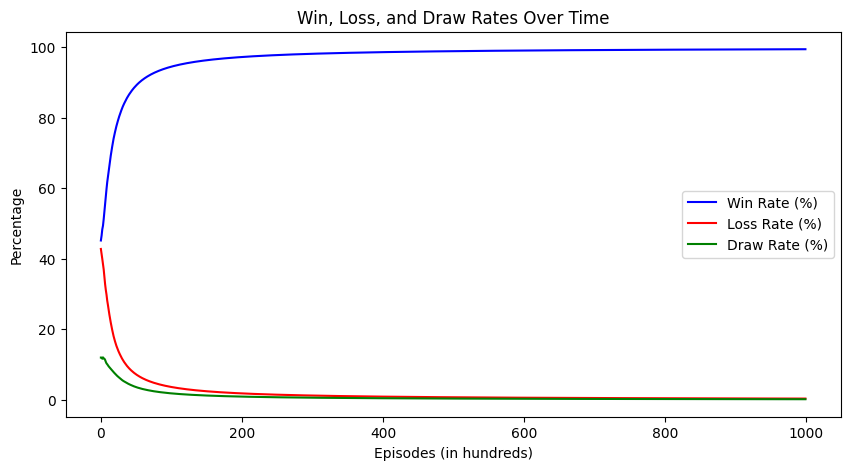

In [ ]:
# Plotting Win, Loss, and Draw Rates
plt.figure(figsize=(10, 5))
plt.plot(win_rates, label='Win Rate (%)', color='blue')
plt.plot(loss_rates, label='Loss Rate (%)', color='red')
plt.plot(draw_rates, label='Draw Rate (%)', color='green')
plt.xlabel('Episodes (in hundreds)')
plt.ylabel('Percentage')
plt.title('Win, Loss, and Draw Rates Over Time')
plt.legend()
plt.show()


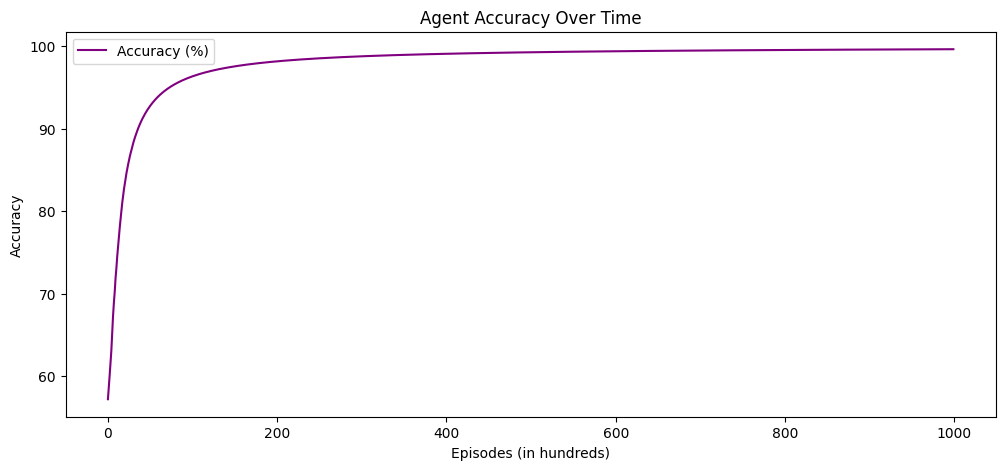

In [ ]:
# Plotting Accuracy Over Time
plt.figure(figsize=(12, 5))
plt.plot(accuracies, label='Accuracy (%)', color='purple')
plt.xlabel('Episodes (in hundreds)')
plt.ylabel('Accuracy')
plt.title('Agent Accuracy Over Time')
plt.legend()
plt.show()


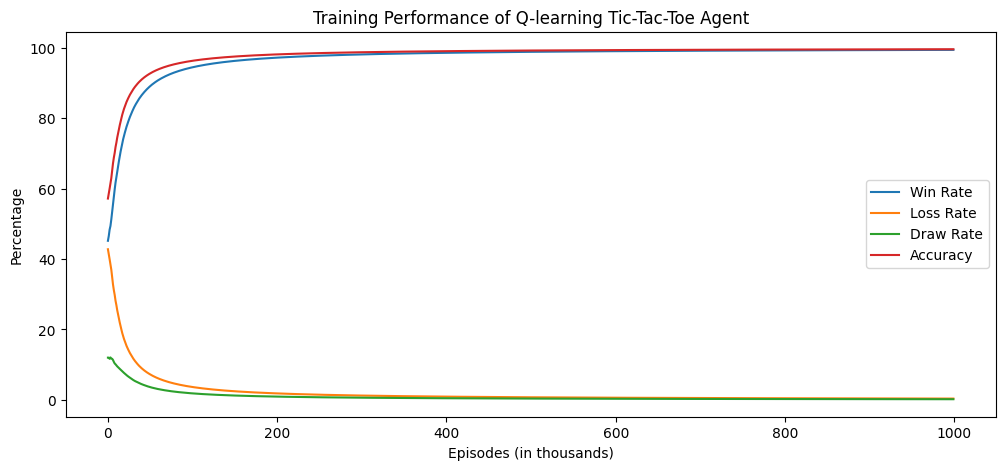

In [ ]:
# Plotting results
plt.figure(figsize=(12, 5))
plt.plot(win_rates, label='Win Rate')
plt.plot(loss_rates, label='Loss Rate')
plt.plot(draw_rates, label='Draw Rate')
plt.plot(accuracies, label='Accuracy')
plt.xlabel('Episodes (in thousands)')
plt.ylabel('Percentage')
plt.legend()
plt.title('Training Performance of Q-learning Tic-Tac-Toe Agent')
plt.show()

In [ ]:
# Final Results
total_games = wins + losses + draws
win_percentage = (wins / total_games) * 100
loss_percentage = (losses / total_games) * 100
draw_percentage = (draws / total_games) * 100
accuracy = (wins + draws / 2) / total_games * 100

print("Final Results after Training:")
print(f"Win Percentage: {win_percentage:.2f}%")
print(f"Loss Percentage: {loss_percentage:.2f}%")
print(f"Draw Percentage: {draw_percentage:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")


Final Results after Training:
Win Percentage: 99.44%
Loss Percentage: 0.37%
Draw Percentage: 0.19%
Accuracy: 99.54%


# **6. Human vs Agent Game**

Allow a human player to play against the trained agent and observe its performance. Use human moves to retrain the Q-table.


In [ ]:
# Main loop for human vs agent game
print("Human vs Agent Game:")
board = np.array([[' ', ' ', ' '], [' ', ' ', ' '], [' ', ' ', ' ']])
current_player = random.choice(players)
game_over = False
while not game_over:
    if current_player == 'X':
        print_board(board)
        row = int(input("Enter the row (0-2): "))
        col = int(input("Enter the column (0-2): "))
        action = (row, col)
        reward = -1.5  # Assume agent loses if human wins
    else:
        action = choose_action(board, exploration_rate)
        reward = 1.5  # Reward agent for winning move

    row, col = action
    if row < 0 or row > 2 or col < 0 or col > 2 or board[row, col] != ' ':
        print("Invalid move. Try again.")
        continue

    board[row, col] = current_player
    game_over, winner = is_game_over(board)

    if current_player == 'X':
        save_human_moves(board, action, reward)

    if game_over:
        print_board(board)
        if winner == 'X':
            print("Human player wins!")
            human_played_games.append((board_to_string(board), action, -1))
        elif winner == 'O':
            print("Agent wins!")
            human_played_games.append((board_to_string(board), action, 1))
        else:
            print("It's a draw!")
            human_played_games.append((board_to_string(board), action, 0.5))

        # Capture the Q-table before retraining
        q1 = {state: q.copy() for state, q in Q.items()}  # Create a copy of Q-table

        # Retrain the agent with human moves
        update_q_from_human_moves()
        print("Retraining the agent...")

        # Compare Q-table after retraining
        q_updated = False
        for state in Q:
            if not np.array_equal(q1.get(state), Q[state]):
                q_updated = True
                break

        if not q_updated:
            print("No retraining DONE")
        else:
            print("Retraining DONE")

        # Clear human moves after retraining
        human_played_games.clear()  # Clear after updating Q-table
    else:
        current_player = players[(players.index(current_player) + 1) % num_players]


Human vs Agent Game:
   |   |   
---+---+---
   |   |   
---+---+---
   | O |   
Enter the row (0-2): 0
Enter the column (0-2): 0
 X | O |   
---+---+---
   |   |   
---+---+---
   | O |   
Enter the row (0-2): 1
Enter the column (0-2): 1
 X | O |   
---+---+---
   | X |   
---+---+---
 O | O |   
Enter the row (0-2): 2
Enter the column (0-2): 2
 X | O |   
---+---+---
   | X |   
---+---+---
 O | O | X 
Human player wins!
Updating Q-table from human moves...
Updated Q-value for state X      O , action (0, 0): 0.0 -> -0.011628514254355073
Updated Q-value for state XO  X  O , action (1, 1): 0.0 -> -0.014995818849658733
Retraining the agent...
Retraining DONE
